In [1]:
import numpy as np
import pandas as pd
import gymnasium as gym
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
env = gym.make("MountainCar-v0")

In [3]:
EPSILON = 1.0
EPSILON_DECAY = 0.999
GAMMA = 0.99
TARGET_UPDATE_FREQ = 1000
BUFFER_SIZE = 100000
BATCH_SIZE = 64
NUM_EPISODES = 1500
ACTIONS = env.action_space.n
OBSERVATIONS = env.observation_space.shape[0]

In [4]:
Q_network = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation="relu", input_shape=(OBSERVATIONS,)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(ACTIONS, activation="linear")
])

Target_network = tf.keras.models.clone_model(Q_network)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [5]:
def greedy_policy(state, epsilon=0.0):
    if np.random.random() <= epsilon:
        return env.action_space.sample()
    else:
        state = tf.expand_dims(state, axis=0)
        q_values = Q_network(state)
        return np.argmax(q_values.numpy()[0])

In [6]:
REPLAY_BUFFER = []


def add_transitions(state, action, reward, next_state, done):
    REPLAY_BUFFER.append((state, action, reward, next_state, done))
    if len(REPLAY_BUFFER) > BUFFER_SIZE:
        REPLAY_BUFFER.pop(0)


def sample_transitions(batch_size=16):
    random_indices = np.random.randint(low=0, high=len(REPLAY_BUFFER), size=batch_size)
    sampled_states = []
    sampled_actions = []
    sampled_rewards = []
    sampled_next_states = []
    sampled_dones = []

    for i in random_indices:
        state, action, reward, next_state, done = REPLAY_BUFFER[i]
        sampled_states.append(state)
        sampled_actions.append(action)
        sampled_rewards.append(reward)
        sampled_next_states.append(next_state)
        sampled_dones.append(done)

    return tf.convert_to_tensor(sampled_states), tf.convert_to_tensor(sampled_actions), tf.convert_to_tensor(sampled_rewards), tf.convert_to_tensor(sampled_next_states), tf.convert_to_tensor(sampled_dones)

In [7]:
initial_states = []

state, info = env.reset()
for i in range(20):
    initial_states.append(state)
    action = greedy_policy(state)
    state, reward, terminated, truncated, info = env.step(action)
    if truncated or terminated:
        break


def get_initial_q_values(states):
    q_values = Q_network(states)
    return tf.reduce_max(q_values, axis=1)

In [8]:
metrics = {"episode": [], "episode_length": [], "total_reward": [], "epsilon": [], "avg_q_value": []}
step_counter = 0

for episode in range(NUM_EPISODES):
    state, info = env.reset()
    done = False

    total_reward = 0
    episode_len = 0

    while not done:
        action = greedy_policy(state, EPSILON)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        add_transitions(state, action, reward, next_state, done)
        s_states, s_actions, s_rewards, s_next_states, s_dones = sample_transitions(BATCH_SIZE)
        
        next_action_values = tf.reduce_max(Target_network(s_next_states), axis=1)
        targets = tf.where(s_dones, s_rewards, s_rewards + GAMMA * next_action_values)

        with tf.GradientTape() as tape:
            q_values = Q_network(s_states)
            action_indices = tf.stack([tf.range(BATCH_SIZE), s_actions], axis=1)
            current_action_values = tf.gather_nd(q_values, action_indices)

            loss = tf.keras.losses.Huber()(targets, current_action_values) # Huber loss is used instead of MSE for error clipping

        grads = tape.gradient(loss, Q_network.trainable_variables)
        optimizer.apply_gradients(zip(grads, Q_network.trainable_variables))

        if step_counter % TARGET_UPDATE_FREQ == 0:
            Target_network.set_weights(Q_network.get_weights())

        state = next_state

        total_reward += reward
        episode_len += 1
        step_counter += 1

        done = terminated or truncated
    
    avg_q_metric = tf.reduce_mean(get_initial_q_values(tf.convert_to_tensor(initial_states))).numpy()
      
    metrics["episode"].append(episode)
    metrics["episode_length"].append(episode_len)
    metrics["total_reward"].append(total_reward)
    metrics["epsilon"].append(EPSILON)
    metrics["avg_q_value"].append(avg_q_metric)

    print(f"Episode {episode}: Total Reward: {total_reward}, Episode Length: {episode_len}, Epsilon: {EPSILON}, Avg. Q-Value: {avg_q_metric}")

    EPSILON = max(0.01, EPSILON * EPSILON_DECAY)
    metrics_df = pd.DataFrame(metrics)
    metrics_df.to_csv("models/DQN_mountaincar_metrics.csv", index=False)

print("Training Completed!")
Q_network.save("models/DQN_mountaincar")
env.close()

Episode 0: Total Reward: -200.0, Episode Length: 200, Epsilon: 1.0, Avg. Q-Value: -0.8907874822616577
Episode 1: Total Reward: -200.0, Episode Length: 200, Epsilon: 0.999, Avg. Q-Value: -0.8954723477363586
Episode 2: Total Reward: -200.0, Episode Length: 200, Epsilon: 0.998001, Avg. Q-Value: -0.9025262594223022
Episode 3: Total Reward: -200.0, Episode Length: 200, Epsilon: 0.997002999, Avg. Q-Value: -0.8987916707992554
Episode 4: Total Reward: -200.0, Episode Length: 200, Epsilon: 0.996005996001, Avg. Q-Value: -0.8912652730941772
Episode 5: Total Reward: -200.0, Episode Length: 200, Epsilon: 0.995009990004999, Avg. Q-Value: -1.8880354166030884
Episode 6: Total Reward: -200.0, Episode Length: 200, Epsilon: 0.994014980014994, Avg. Q-Value: -1.8928890228271484
Episode 7: Total Reward: -200.0, Episode Length: 200, Epsilon: 0.993020965034979, Avg. Q-Value: -1.8832381963729858
Episode 8: Total Reward: -200.0, Episode Length: 200, Epsilon: 0.9920279440699441, Avg. Q-Value: -1.8933565616607666

INFO:tensorflow:Assets written to: models/DQN_mountaincar\assets


In [9]:
env = gym.make('MountainCar-v0', render_mode="human")

Q_network = tf.keras.models.load_model("models/DQN_mountaincar")

NUM_EPISODES = 10

for episode in range(NUM_EPISODES):
    total_reward = 0
    episode_len = 0
    
    state, info = env.reset()
    done = False

    while not done:
        q_values = Q_network(tf.expand_dims(state, axis=0))
        action = np.argmax(q_values.numpy()[0])
        state, reward, terminated, truncated, info = env.step(action)

        total_reward += reward
        episode_len += 1

        done = terminated or truncated

    print(f"Episode {episode}: Total Reward: {total_reward}, Episode Length: {episode_len}")
    
env.close()

Episode 0: Total Reward: -120.0, Episode Length: 120
Episode 1: Total Reward: -128.0, Episode Length: 128
Episode 2: Total Reward: -118.0, Episode Length: 118
Episode 3: Total Reward: -133.0, Episode Length: 133
Episode 4: Total Reward: -132.0, Episode Length: 132
Episode 5: Total Reward: -120.0, Episode Length: 120
Episode 6: Total Reward: -132.0, Episode Length: 132
Episode 7: Total Reward: -132.0, Episode Length: 132
Episode 8: Total Reward: -132.0, Episode Length: 132
Episode 9: Total Reward: -131.0, Episode Length: 131


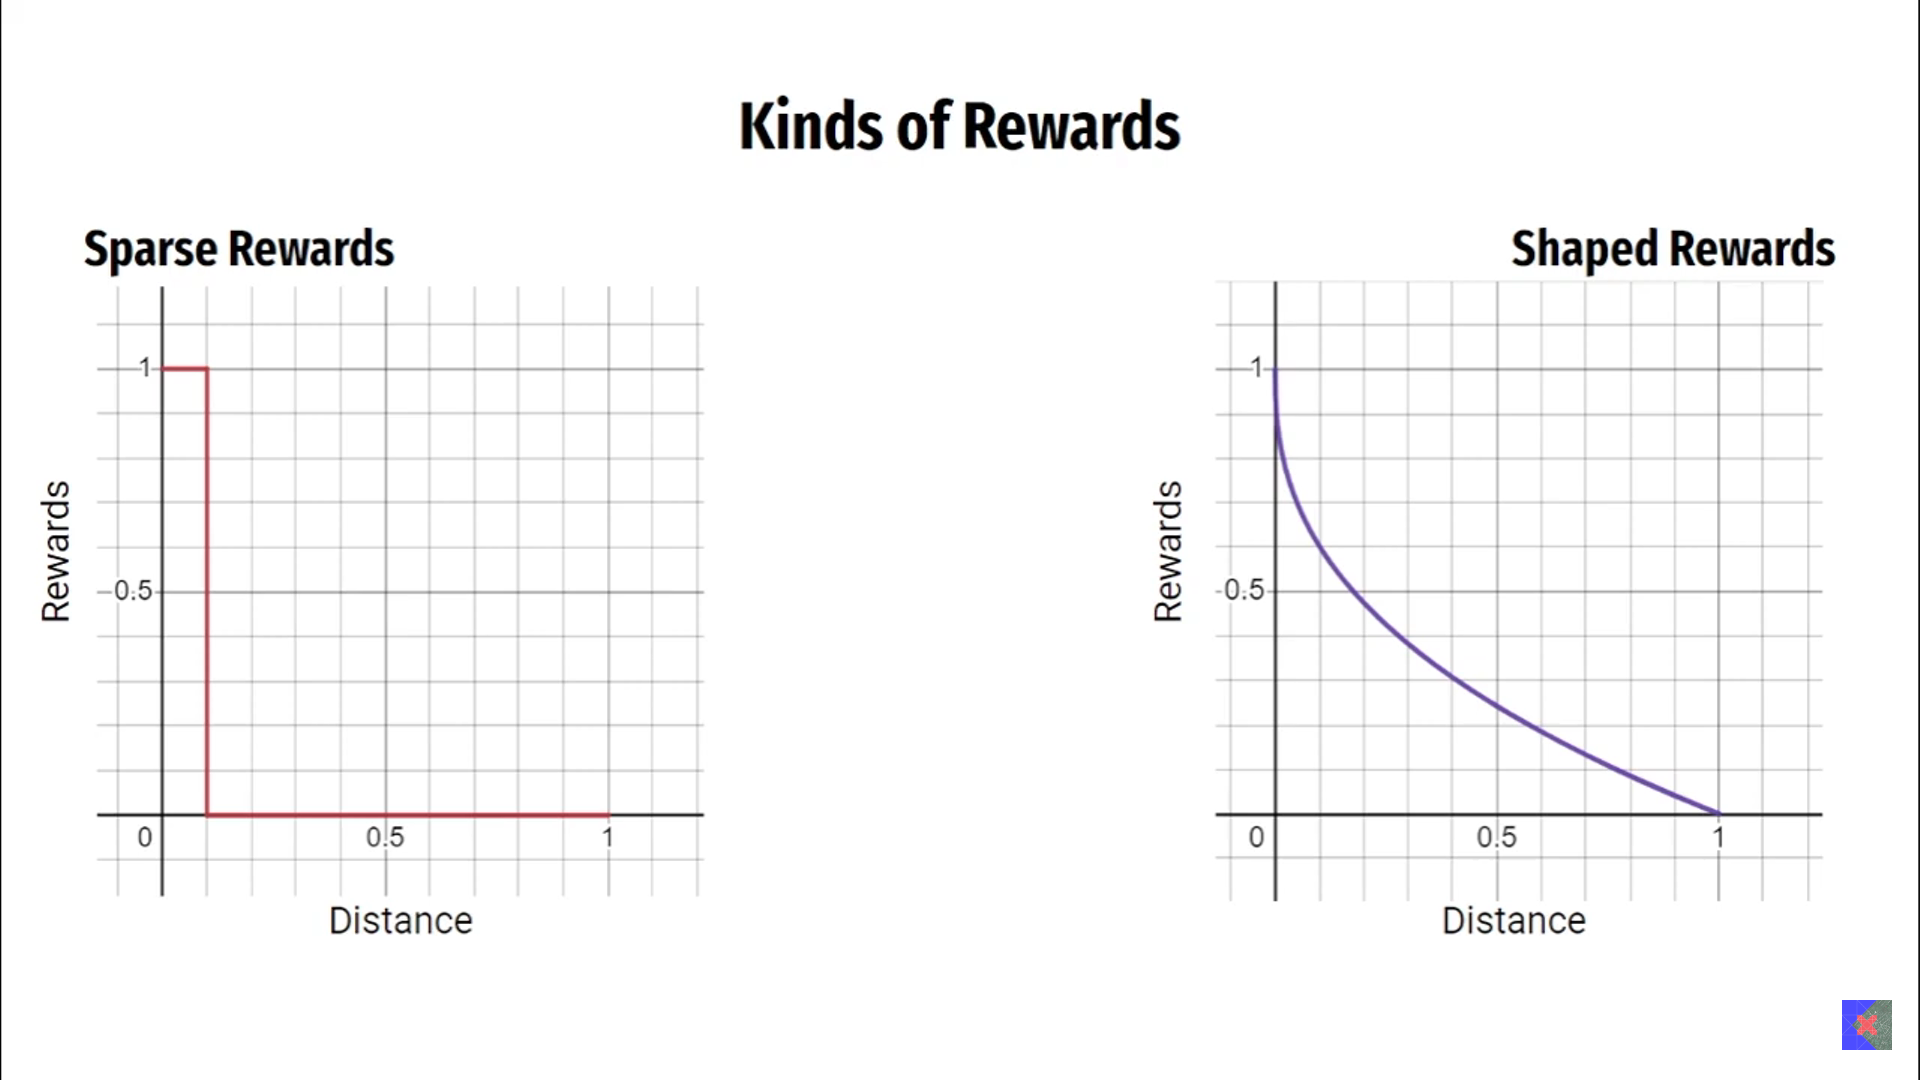